# H1B-Visa Exploration
## Thomas Harrington

#### In this notebook, we investigate the H-1B visa application data for 2014.

### Importing the necessary packages

In [1]:
import pandas as pd
import numpy as np
import difflib
import re

import matplotlib.pyplot as plt

from collections import Counter
import itertools

from scipy import stats

from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import roc_auc_score, confusion_matrix, roc_curve, auc
#from sklearn.cross_validation import StratifiedKFold
from sklearn.model_selection import StratifiedKFold

#Jupyter notebook specific 
from IPython.core.display import display, HTML
%matplotlib inline

Let's load the data into a Pandas DataFrame and look at the head to begin exploring the data.

In [2]:
df_data = pd.read_csv('db246968-e567-442f-8108-b86a280107d3.csv')

In [3]:
df_data.head()

,lca_case_number,status,lca_case_submit,decision_date,visa_class,lca_case_employment_start_date,lca_case_employment_end_date,lca_case_employer_name,lca_case_employer_address,lca_case_employer_city,...,other_wage_source_1,yr_source_pub_1,lca_case_workloc2_city,lca_case_workloc2_state,pw_2,pw_unit_2,pw_source_2,other_wage_source_2,yr_source_pub_2,lca_case_naics_code
0,I-200-09106-546545,CERTIFIED-WITHDRAWN,2013-01-18,2014-09-29,H-1B,2013-02-01,2016-02-01,TEXAS STATE UNIVERSITY-SAN MARCOS,601 UNIVERSITY DRIVE,SAN MARCOS,...,OFLC ONLINE DATA CENTER,2013.0,ST. LOUIS,MO,49566.0,Year,OES,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,611310.0
1,I-200-09162-143337,CERTIFIED,2014-03-17,2014-03-21,H-1B,2014-09-15,2017-09-15,"EYE SPECIALISTS OF INDIANA, P.C.",1901 N. MERIDIAN ST.,INDIANAPOLIS,...,OFLC ONLINE DATA CENTER,2013.0,INDIANAPOLIS,IN,64251.0,Year,Other,OFLC ONLINE DATA CENTER,OFLC ONLINE DATA CENTER,621320.0
2,I-200-09182-550211,DENIED,2014-03-14,2014-03-20,H-1B,2014-04-01,2015-04-01,"LHB, INC.",21 WEST SUPERIOR STREET,DULUTH,...,OFLIC ONLINE,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541330.0
3,I-200-09193-873099,CERTIFIED,2014-03-01,2014-03-06,H-1B,2014-08-28,2017-08-27,"WAM USA, INC.",75 BOULDERBROOK CIRCLE,LAWRENCEVILLE,...,OFLC ONLINE DATA CENTER,2014.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,333922.0
4,I-200-09197-120609,CERTIFIED-WITHDRAWN,2014-03-10,2014-03-17,H-1B,2014-09-01,2017-09-01,"DFUSE TECHNOLOGIES, INC.",20143 DESERT FOREST DRIVE,ASHBURN,...,OFLC ONLINE DATA CENTER,2013.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,541519.0


In [4]:
print('There are {:.0f} visa applications in this dataset.'.format(df_data.shape[0]))

There are 517435 visa applications in this dataset.


There are many columns contained in the data. We could use df_data.head() to see the names of all the columns. Let's first check if the data consists entirely of H-1B visas by looking at the values and counts.

In [5]:
df_data.visa_class.value_counts()

H-1B               506650
E-3 Australian       9409
H-1B1 Singapore       821
H-1B1 Chile           555
Name: visa_class, dtype: int64

A majority of the visa_class values are H-1B as expected. The visas from Singapore, Chile, and Australia have their own categories. We will be investigating the H-1B visas in NYC and Mountain view, so we can focus on the data where visa_class is equal to 'H-1B'. Let's create a df with just the H-1B visas.

In [6]:
df_h1b = df_data[df_data.visa_class=='H-1B'].drop('visa_class',axis=1)

## Section 1: Investigating the Data

### Question 1: Which companies applied for the largest number of H-1B visas where the job opening was located in NYC?

Now, we want to get the data for visas where the job opening was located in NYC. We will start first by creating a DataFrame where the work location state (the lca_case_workloc1_state field) is NY.

In [7]:
df_h1b_ny = df_h1b[map(lambda x: x[1].lca_case_workloc1_state=='NY'
                       or x[1].lca_case_workloc2_state=='NY',
                       df_h1b.iterrows())]
print('There are {:.0f} visa applications for jobs located in NY in this dataset.'.format(df_h1b_ny.shape[0]))

There are 48039 visa applications for jobs located in NY in this dataset.


Let's get an idea of the values for the lca_case_workloc1_city field. We want to filter out the jobs that are located in NYC. NYC has five boroughs so there are a number of ways the city could be specified to refer to NYC. After looking at the possible values, a list of cities refering to NYC was created and then a DataFrame consisting of jobs located in NYC was created. This list is not exhaustive. Given the time constraint, the list of cities was quickly produced by looking through a list of the unique city entries. Also, it was built after filtering through the dataset and only taking states that match 'NY'. There is a chance that there are entries where the state was mispelt, but those haven't been searched for within the dataset. 

In [8]:
ny_cities_list = sorted(df_h1b_ny.lca_case_workloc1_city.unique())

In [9]:
nyc_names = ['NEW YORK',
             'BRONX',
             'BRONX, NEW YORK',
             'BRONX,NEW YORK',
             'BRONX,NY',
             'BRONX.NEW YORK',
             'BROOKLN',
             'BROOKLY',
             'BROOKLYN',
             'BROOKLYN,',
             'BROOKYLN',
             'BROOKYN',
             'NEW YORK CITY',
             'LONG IS CITY',
             'LONG ISLAD CITY',
             'LONG ISLAND',
             'LONG ISLAND CITY',
             'LONG ISLAND CITY,',
             'LONG ISLAND CITY, QUEENS',
             'LONG ISLAND CTY',
             'LONG ISLANDY CITY',
             'LONGISLAND CITY',
             'QUEENS',
             'MANHATTAN',
             'MANHATAN',
             'MANHATTAN',
             'MANHATTAN, NEW YORK',
             'METRO NEW YORK',
             'NYC',
             'NEW YOK',
             'NEW YORK',
             'NEW YORK CITY',
             'NEW YORK CITY,',
             'NEW YORK,',
             'NEW YORK, 10003',
             'NEW YORK, NEW YORK',
             'NEW YORK, NY',
             'NEW YORK, NY -',
             'NEW YORK,NEW YORK',
             'NEW YOUR',
             'NEW YOURK',
             'NEW YROK',
             'NY']
df_h1b_nyc = df_h1b[map(lambda x: x[1].lca_case_workloc1_city in nyc_names
                        or x[1].lca_case_workloc2_state in nyc_names,
                        df_h1b.iterrows())]

The df_h1b_nyc DataFrame contains all of the H-1B visa data where either the workloc1 or workloc2 field was one of the strings in the list above. We can use a value_counts on the lca_case_employer_name field to see the number of companies. Here I have chosen to list the top 10 companies.

In [10]:
df_h1b_nyc.lca_case_employer_name.value_counts()[:10]

ERNST & YOUNG U.S. LLP                1120
DELOITTE CONSULTING LLP                598
JPMORGAN CHASE & CO.                   564
TATA CONSULTANCY SERVICES LIMITED      478
INFOSYS LIMITED                        470
MORGAN STANLEY & CO. LLC               427
GOLDMAN, SACHS & CO.                   385
BLOOMBERG, LP                          333
CREDIT SUISSE SECURITIES (USA) LLC     286
CITIBANK, N.A.                         285
Name: lca_case_employer_name, dtype: int64

<div class="alert alert-block alert-success">
<h4>
We can see that 'ERNST & YOUNG U.S. LLP' applied for the largest number of H-1B visas for jobs located in NYC. 
<br><br>
We have to be careful about using counts on unique strings because there are many ways that the strings representing the same company could be written. For example, 'JPMORGAN CHASE & CO.' appears in multiple different ways as seen below. If we count all of appearances in its various forms, we see that 'JPMORGAN CHASE & CO.' is actually in second place with 625 applications unless 'DELOITTE & TOUCHE LLP' or similar companies including 'DELOITTE' are all part of 'DELOITTE CONSULTING LLP'

</h4>
</div>

In [11]:
df_h1b_nyc[map(lambda x: ('JP' in x[1].lca_case_employer_name and 'CHASE' in x[1].lca_case_employer_name),
               df_h1b_nyc.iterrows())].lca_case_employer_name.value_counts()

JPMORGAN CHASE & CO.        564
JPMORGAN CHASE &AMP; CO.     49
JPMORGAN CHASE & CO          10
JPMORGAN CHASE CO.            1
JPMORGAN CHASE &CO.           1
Name: lca_case_employer_name, dtype: int64

In [12]:
sum(df_h1b_nyc[map(lambda x: ('JP' in x[1].lca_case_employer_name and 'CHASE' in x[1].lca_case_employer_name),
               df_h1b_nyc.iterrows())].lca_case_employer_name.value_counts())

625

In [13]:
df_h1b_nyc[map(lambda x: 'DELOITTE' in x[1].lca_case_employer_name,
               df_h1b_nyc.iterrows())].lca_case_employer_name.value_counts()

DELOITTE CONSULTING LLP                             598
DELOITTE & TOUCHE LLP                               178
DELOITTE TAX LLP                                     41
DELOITTE TRANSACTIONS AND BUSINESS ANALYTICS LLP     31
DELOITTE &AMP; TOUCHE LLP                            24
DELOITTE LLP                                          9
DELOITTE FINANCIAL ADVISORY SERVICES LLP              8
DELOITTE ANALYTICS LLC                                2
DELOITTE CONSULTING OVERSEAS PROJECTS LLC             1
DELOITTE TOUCHE LLP                                   1
DELOITTE CORPORATE FINANCE LLC                        1
DELOITTE TOUCHE TOHMATSU SERVICES, INC.               1
DELOITTE &TOUCHE LLP                                  1
DELOITTE SERVICES LP                                  1
Name: lca_case_employer_name, dtype: int64

### Calculating the mean and standard deviation of wages proposed for workers located in New York City and Mountain View. Are the average wages in these two locations statistically different? If so, what factors could explain the results?

#### New York City

We already have the NYC data ready to compute the mean and standard deviation of wages. First, let's investigate the wages (pw_1 field).

In [14]:
df_h1b_nyc.pw_1.describe()

count    3.684000e+04
mean     8.675021e+04
std      3.214249e+06
min      9.000000e+00
25%      5.341400e+04
50%      6.712200e+04
75%      8.937800e+04
max      6.169317e+08
Name: pw_1, dtype: float64

As seen in the summary above, the max is extremely large (616931700). This is most likely a mistake because the entry is \$616 million. There are five salaries are over \$500,000. For each of those cases, the salary is significantly different from the listed lca_case_wage_rate_to and lca_case_wage_rate_from fields. Below, I have filtered out those wages above \$300,000. As we can see, many of these values seem way off. Out of the entries below, only two have wages that seem realistic based off of the wages_from and wages_to fields. We drop the outliers.

In [15]:
df_h1b_nyc[df_h1b_nyc.pw_1>300000][['pw_1','lca_case_wage_rate_from','lca_case_wage_rate_to']]

,pw_1,lca_case_wage_rate_from,lca_case_wage_rate_to
33359,890000.0,100001.0,NaN
66488,565997.0,60000.0,NaN
104536,336343.0,40000.0,NaN
115844,378900.0,624000.0,NaN
166920,767100.0,93500.0,140000.0
254903,378900.0,624000.0,NaN
279967,616931693.0,65000.0,NaN
342136,6468800.0,76320.0,NaN
426706,360000.0,29567.0,NaN


In [16]:
df_h1b_nyc = df_h1b_nyc.drop([33359, 66488, 104536, 166920, 279967, 342136,426706])

In [17]:
print('There are {:.0f} visa applications for jobs located in NYC in this dataset.'.format(df_h1b_nyc.shape[0]))

There are 36836 visa applications for jobs located in NYC in this dataset.


We also need to check to make sure none of the wage values are missing. We use isnull() to check this and then drop the entries that are null.

In [18]:
df_h1b_nyc[df_h1b_nyc.pw_1.isnull()].pw_1

60049    NaN
275446   NaN
396316   NaN
Name: pw_1, dtype: float64

In [19]:
df_h1b_nyc = df_h1b_nyc.drop([60049,396316,275446])

Now, we want to make sure the average wages are computed for full time jobs. The data contains many entries where the wage rate is specified hourly. For some of the hourly wages, pw_1 is specified as a yearly amount, but for some the pw_1 field is specified as an hourly rate. This is seen by looking at the pw_unit_1 field. Before averaging we need to make sure that these fields are corrected to annual wages. A small function was created to modify these entries.

In [20]:
df_h1b_nyc_ft = df_h1b_nyc[df_h1b_nyc.full_time_pos=='Y']
print('There are {:.0f} visa applications for full-time jobs located in NYC in this dataset.'.format(df_h1b_nyc_ft.shape[0]))


There are 34988 visa applications for full-time jobs located in NYC in this dataset.


In [21]:
df_h1b_nyc_ft.pw_unit_1.value_counts()

Year     33364
Hour      1598
Week        13
Month       13
Name: pw_unit_1, dtype: int64

In [22]:
def fix_wages(dataframe, thresh_week, thresh_month, thresh_hour):
    '''
    dataframe: the Pandas DataFrame whose values will be modified
    thresh_: are the weekly, monthly, and hourly thresholds that are set to ensure the 
    wages aren't modified if they actually correspond to the correct annual wages.
    Some pw_unit values are stated as one of the categories that isn't yearly, but then
    an annual salary is given. We don't want to modify those entries so we use thresholds. 
    '''
    for x,y in dataframe.iterrows():
        if y.pw_unit_1 == 'Week' and y.pw_1 < thresh_week:
            dataframe.loc[x,'pw_1'] = y.pw_1*52
        elif y.pw_unit_1 == 'Month' and y.pw_1 < thresh_month:
            dataframe.loc[x,'pw_1'] = y.pw_1*12
        elif y.pw_unit_1 == 'Hour' and y.pw_1 < thresh_hour:
            dataframe.loc[x,'pw_1'] = y.pw_1*40*52

In [23]:
fix_wages(df_h1b_nyc_ft,6000,35000,500)

/Users/Tom/anaconda2/envs/insight_env/lib/python2.7/site-packages/pandas/core/indexing.py:477: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


After fixing the wages, we can compute the mean and the std using describe(). A histogram of wages is shown below

In [24]:
df_h1b_nyc_ft.pw_1.describe()

count     34988.000000
mean      76304.798820
std       29660.846709
min       16424.000000
25%       56826.000000
50%       68557.000000
75%       91104.000000
max      378900.000000
Name: pw_1, dtype: float64

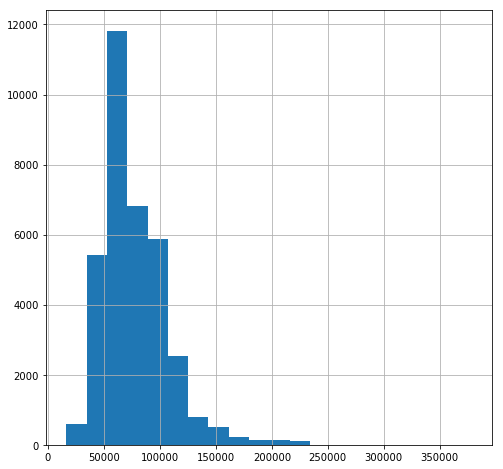

In [25]:
df_h1b_nyc_ft.pw_1.hist(bins=20,figsize=(8,8))

Note: The results above show the average wage of the visa applications. Some visa applications are for multiple workers. If we want an average over all the number of workers covered by the H-1B visa applications submitted, we can use a weighted average, which is shown below.

In [26]:
sum(df_h1b_nyc_ft.pw_1*df_h1b_nyc_ft.total_workers)/sum(df_h1b_nyc_ft.total_workers)

74592.827375026507

As we can see, this average changes varies slightly from the average computed earlier.

#### Mountain View

Now we need to do the same thing for Mountain View. Let's first make a list of CA cities appearing in the data set and then look for strings that could stand for Mountain View

In [27]:
ca_cities_list = sorted(df_h1b[df_h1b.lca_case_employer_state=='CA'].lca_case_workloc1_city.unique())

In [28]:
mv_names = ['MOUNATIN VIEW',
            'MOUNTAIN VIE',
            'MOUNTAIN VIEW',
            'MOUNTAIN VIEW,',
            'MOUNTAIN VIEW, CA 94043',
            'MOUNTAIN VIEW\\',
            'MOUNTAINVIEW',
            'MOUNTIAN VIEW']
df_h1b_mv = df_h1b[map(lambda x: x[1].lca_case_workloc1_city in mv_names
                        or x[1].lca_case_workloc2_state in mv_names,
                        df_h1b.iterrows())]

In [29]:
df_h1b_mv.pw_1.describe()

count      5169.000000
mean      96610.934922
std       28642.186040
min          22.370000
25%       80746.000000
50%       98675.000000
75%      114421.000000
max      987675.000000
Name: pw_1, dtype: float64

In [30]:
df_h1b_mv[df_h1b_mv.pw_1>700000][['pw_1','lca_case_wage_rate_from','lca_case_wage_rate_to']]

,pw_1,lca_case_wage_rate_from,lca_case_wage_rate_to
123031,987675.0,105000.0,NaN


Out of the entries for Mountain View, most look like they are valid wages except the one shown above. We remove this since it is likely a typo. If the salary was around 98700, it would make sense given the lca_case_wage_from entry.

In [31]:
df_h1b_mv = df_h1b_mv.drop([123031])

In [32]:
print('There are {:.0f} visa applications for jobs located in Mountain View in this dataset.'.format(df_h1b_mv.shape[0]))

There are 5168 visa applications for jobs located in Mountain View in this dataset.


In [33]:
df_h1b_mv.pw_1.describe()

count      5168.000000
mean      96438.515404
std       25823.192846
min          22.370000
25%       80746.000000
50%       98675.000000
75%      114421.000000
max      224536.000000
Name: pw_1, dtype: float64

Now, we want to make sure the average wages are computed for full time jobs like we did for the NYC data.

In [34]:
df_h1b_mv_ft = df_h1b_mv[df_h1b_mv.full_time_pos=='Y']
print('There are {:.0f} visa applications for full-time jobs located in Mountain View in this dataset.'.format(df_h1b_mv_ft.shape[0]))


There are 5142 visa applications for full-time jobs located in Mountain View in this dataset.


In [35]:
df_h1b_mv_ft.pw_unit_1.value_counts()

Year     5089
Hour       51
Month       2
Name: pw_unit_1, dtype: int64

In [36]:
fix_wages(df_h1b_mv_ft, 6000, 35000, 500)

After fixing the wages, we can compute the mean and the std using describe(). A histogram of wages is shown below

In [37]:
df_h1b_mv_ft.pw_1.describe()

count      5142.000000
mean      97711.014197
std       23255.652140
min       23192.000000
25%       80746.000000
50%       98675.000000
75%      114421.000000
max      224536.000000
Name: pw_1, dtype: float64

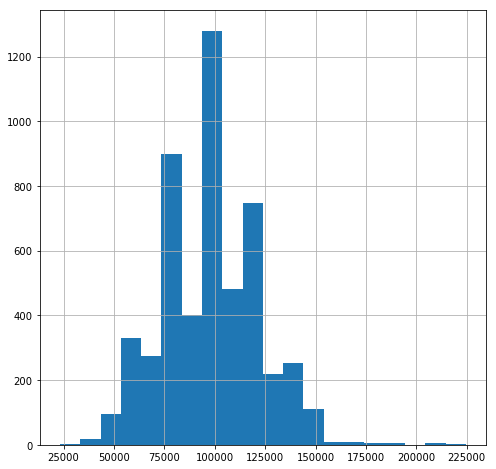

In [38]:
df_h1b_mv_ft.pw_1.hist(bins=20,figsize=(8,8))

Once again, we want to see how the average changes if we take into account the fact that visa applications can represent multiple workers.

In [39]:
sum(df_h1b_mv_ft.pw_1*df_h1b_mv_ft.total_workers)/sum(df_h1b_mv_ft.total_workers)

96677.25448350067

#### Statistical Significance

Let's recall the summary for the annual wages in NYC and Mountain View

In [40]:
df_h1b_nyc_ft.pw_1.describe()

count     34988.000000
mean      76304.798820
std       29660.846709
min       16424.000000
25%       56826.000000
50%       68557.000000
75%       91104.000000
max      378900.000000
Name: pw_1, dtype: float64

In [41]:
df_h1b_mv_ft.pw_1.describe()

count      5142.000000
mean      97711.014197
std       23255.652140
min       23192.000000
25%       80746.000000
50%       98675.000000
75%      114421.000000
max      224536.000000
Name: pw_1, dtype: float64

We want to determine if the average wages in the two areas are statistically different. To do this, we run a T-test using the Scipy stats ttest_ind function. We make sure that the variances of each of the wages are not assumed to be equal. The T-test measures whether the average value differs significantly across the two samples. The null hypothesis being tested is that the two cities average wages are the same. 

In [42]:
stats.ttest_ind(df_h1b_nyc_ft.pw_1,df_h1b_mv_ft.pw_1, equal_var = False)

Ttest_indResult(statistic=-59.296585270744501, pvalue=0.0)

<div class="alert alert-block alert-success">
<h4>
The T-test returned a pvalue of 0 which means that we can reject the null hypothesis that the two sample means are the same. 
<br><br>
This means that the average wages in NYC and Mountain View are statistically different.
<br><br>
The differences in average wages between the two cities ia most likely the result of many factors.
<br><br>
The two cities are well known in different industries. NYC is home to many Media, Finance/Investment Firms, and Advertising companies, whereas Mountain View is home to many Tech companies. The jobs types are not unique to each city, but the proportions of jobs available in each industry are different. The average pay and number of jobs in each of these industries is not the same. It's possible that the pay difference between the different industries and the difference in percentage of jobs in each industry explain the difference in average wages between NYC and Mountain View. 
<br><br>
I have read multiple reports that the cost of living (all included) is higher in Mountain View than NYC, but more conclusive evidence would be needed to verify these statements. A higher cost of living would justify a higher salary, but there may be more to it. A proper investigation into the types of jobs in these two locations for the H-1B visa would yield some insight into this difference. 
<br><br>
As shown below, approximately 1% of the H-1B visa wage applications are stated with hourly rates in Mountain View, compared to ~4.6% in NYC. More investigation would have to be done to see how the average wages for jobs that pay hourly compare to salaried jobs. Typically professional jobs pay a yearly salary, so I suspect that the hourly rate jobs pay less on average each year. If this is true, then the difference average wages might partially be accounted for due to the larger percentage of hourly jobs in NYC.
</h4>
</div>

In [43]:
df_h1b_mv.pw_unit_1.value_counts()
100.0*df_h1b_mv_ft[df_h1b_mv_ft.pw_unit_1=='Hour'].shape[0]/(df_h1b_mv_ft.shape[0])

0.9918319719953326

In [44]:
100.0*df_h1b_nyc_ft[df_h1b_nyc_ft.pw_unit_1=='Hour'].shape[0]/(df_h1b_nyc_ft.shape[0])

4.567280210357837

### What is the relationship between the total number of H-1B visas requested by an employer and the average wages proposed? Is the relationship statistically significant? What might explain this relationship?

To answer these questions, we need to make sure to match employers properly. This could probably be effectively done using a fuzzy word matching, but since this is a short exploration I will resort to a very quick and dirty approach. Looking at the number of unique company strings and unique addresses, we might think that a good place to start would be to combine companies with the same addresses. However, there is a potential that multiple companies share any single address. Additionally the address strings could appear as slightly different strings making the combination difficult to automate. The company name strings suffer from some of the same issues. 

In [45]:
difflib.SequenceMatcher(None, 'BARCLAYS CAPITAL', 'BARCLAYS CAPITAL, INC.').ratio()

0.8421052631578947

In [46]:
def create_employer_dict(list_employers,threshold):
    '''
    This function takes in a list of employers and a threshold
    It produces a list of companies that are unique (have text similarity scores below the threshold)
    and a dictionary that maps similar companies to ones in the unique list
    '''
    unique_employers = ['BARCLAYS CAPITAL']
    employer_dict = {'BARCLAYS CAPITAL':'BARCLAYS CAPITAL'}
    for x in list_employers:
        scores = [difflib.SequenceMatcher(None, x, z).ratio() for z in unique_employers]
        max_index = np.argmax(scores)
        max_score = scores[max_index]
        if max_score < threshold:
            # The company is not similar to any others
            unique_employers.append(x)
            employer_dict[x] = x
        else:
            # The company is similar to one that already exists in the list
            max_index = np.argmax(scores)
            employer_dict[x] = unique_employers[max_index]
    return employer_dict, unique_employers

In [87]:
employer_dict, unique_employers = create_employer_dict(df_h1b_nyc_ft.lca_case_employer_name.unique(),0.75)

In [84]:
len(test_dict.keys())

8314

In [75]:
df_h1b_nyc_ft.lca_case_employer_name.nunique()

8313

In [77]:
df_h1b_nyc_ft.groupby(['lca_case_employer_address'])['lca_case_employer_name'].unique()

lca_case_employer_address
1 ALEXANDER PLACE                                                         [SCO FAMILY OF SERVICES]
1 AUSTIN AVE.,                                                    [SYNERZY SOFTWARE SOLUTIONS INC]
1 AVON PLAZA                                                                 [AVON PRODUCTS, INC.]
1 BATTERY PARK PLAZA, 3RD FLOOR                                   [WORLD EDUCATION SERVICES, INC.]
1 BLUE HILL PLAZA                                                    [HUDSON TECHNOLOGIES COMPANY]
1 BRIDGE PLAZA                                                            [COESYS SOLUTIONS, INC.]
1 BRIDGE PLAZA NORTH                             [SRNL INTERNATIONAL, INC, SRNL INTERNATIONAL INC]
1 BRIDGE PLAZA NOTRH                                                      [SRNL INTERNATIONAL INC]
1 BROOKDALE PLAZA                                 [BROOKDALE UNIVERSITY HOSPITAL & MEDICAL CENTER]
1 BRYANT PARK, 38TH FLOOR                                           [MARATHON ASSET

In [88]:
df_h1b_nyc_ft.groupby(['lca_case_employer_name']).lca_case_employer_name

In [71]:
df_h1b_nyc_ft.groupby(['lca_case_employer_name'])['total_workers'].sum()

lca_case_employer_name
"I HAVE A DREAM" FOUNDATION                             1.0
1 WAY SOLUTIONS, INC.                                   2.0
1-0 CAPITAL, LLC                                        2.0
1010DATA SERVICES LLC                                   4.0
110 ARCHITECT, P.C.                                     1.0
1100 ARCHITECT PC                                       3.0
116 WEST HOUSTON STREET LLC                             1.0
1199 NATIONAL BENEFIT FUND FOR HEALTH AND HUMAN SE      2.0
1199 SEIU UNITED HEALTHCARE WORKERS EAST                1.0
12K APPAREL NY LLC                                      1.0
139 MEDICAL FACILITY, P.C.                              1.0
13TH STREET ENTERTAINMENT, LLC                          1.0
151 BLEECKER LLC                                        1.0
16TH STREET MEDICAL MANAGEMENT, LLC                     1.0
1ST AVENUE MACHINE USA, INC.                            1.0
1STDIBS.COM, INC.                                       5.0
2 SAAB CONSTRUCTI

In [55]:
df_h1b_nyc_ft.groupby(['lca_case_employer_name'])['pw_1'].mean()

lca_case_employer_name
"I HAVE A DREAM" FOUNDATION                           107245.000000
1 WAY SOLUTIONS, INC.                                  60362.000000
1-0 CAPITAL, LLC                                       67205.000000
1010DATA SERVICES LLC                                  73918.250000
110 ARCHITECT, P.C.                                    49358.000000
1100 ARCHITECT PC                                      48720.666667
116 WEST HOUSTON STREET LLC                            40872.000000
1199 NATIONAL BENEFIT FUND FOR HEALTH AND HUMAN SE     99000.000000
1199 SEIU UNITED HEALTHCARE WORKERS EAST               82472.000000
12K APPAREL NY LLC                                     52000.000000
139 MEDICAL FACILITY, P.C.                             78811.000000
13TH STREET ENTERTAINMENT, LLC                         59738.000000
151 BLEECKER LLC                                       40082.000000
16TH STREET MEDICAL MANAGEMENT, LLC                    65174.200000
1ST AVENUE MACHINE USA, I

In order to have more time for the exploring other questions about the dataset, I decided to skip this investigation after only a short period of time to look at more interesting questions. I began running a text-similarity method on the list of employers, but it was running too slow to get results. With the list of unique employers and the dict to translate employer names to unique employer names, the wages and total workers could be compared by doing a join on the unique employer name. Then the relationship could be investigated using correlation tests. 

## Section 2: Brainstorming

### What interesting questions might this dataset address?

In this section, I brainstorm interesting questions that one might have while investigating this dataset.

<div>
<ol>

<li> Are H-1B visa decisions (rate of acceptances) affected by the industry of the job? In other words, do all industries have the same approval/rejection rates?

<li> How does the wage rate for H-1B visa applications compare to the wage rate for the same job held by a citizen?

<li> What are the most common types of jobs approved in H-1B visa applications?

<li> Do all regions of the United States have the same approval percentage for visa applications? If not, why might the approval rates vary regionally?

<li> Are visa applications more likely to be approved if there are fewer applications in that job industry?

<li> What can be learnt by investigating the time length scale of an application?

<li> How do permanent visa applications (dataset available via Enigma) differ from H-1B visas?
</ol>

</div>

### Scoping these questions
I describe the steps, methodology, and level of effort that would be required to answer each question. The numbered questions above are scoped below.

<div>

<ol>

<li> We first would need to group H-1B visa applications by industry. Most of the effort for answering this question lies in how to organize the job types appearing in the data into well defined industries. Given how much the text varies in the employer name and address fields alone, this task might take a substantial amount of effort before the desired results could be extracted. Upon further investigation into the dataset, the NAICS code contains information about the industry of the job, so this might be significantly easier. After categorizing by industry, we can compute the approval/rejection rate of each industry to compare the industry rates. After computing the rates, we would want to test if the differences in averages across the industries are statistically significant using ANOVA testing. 

<li> Step one for tackling this problem would be to categorize the information in this dataset into job types. Job types can also be extracted from a portion of the NAICS code. We would need to locate a good database containing salary information for all of the job categories we use on the H-1B data. The level of effort required to answer this question depends greatly on the state of the alternative dataset that contains salary information. The comparison after getting both datasets to the stage where averages can be extracted would be straightforward. The method of comparison would be to run statistical significance tests between the H-1B visa data and the salary dataset.

This could also be interesting because it could provide some insight into understanding the effect of H-1B visa employment on salaries in general. 

<li> This is a very straightforward question that would be very simple to answer after job categories are constructed. A value_counts could be applied to the column of data that contains the category. The level of effort would be the level of effort required to categorize jobs (which may or may not be a lengthy task). 

<li> The first step would be to add an additional feature to the data that encorporates a region. The task of adding regional information should be easy since the dataset already contains a field that captures the state. Assigning states to regions could be automated depending on the desired granularity of the regions. If we define regions as subsets of states, it will be more difficult because then we have to try and use the address field which is messier and requires more careful consideration to group. Starting with regions made out of states would be relatively easy to carry out.

<li> Once again, the dataset would need to be grouped by industry. After grouping by industry, we could compute the number of job applications in each industry. Pairing these with the number of approvals, we could compute if there is a statistically significant relationship between the number of approvals and the number of job applications. 

<li> This is an open-ended question that mostly intiates a further investigation into the submission and decision date for the applications in this data. The level of effort is 

</ol>

</div>

## Section 3: Exploration

In this section, I wanted to address a question that requires using the data to build a predictive model. For this portion, I will explore if this dataset can be used to build a predictive model to identify whether or not a visa application will be accepted ('CERTIFIED') or rejected ('DENIED'). Once a well posed question has been identified, it is important skill to be able to use the data to build a model. For this investigation, I will use the ML capabilities of sklearn to build models. To accommodate the short time scale of this investigation, I start with a very simplified model containing features from the dataset that can be easily engineered. In a real application, the subset selection would be done in a more rigorous and systematic manner. Additionally, I will only explore the use of a logistic regression model. In practice multiple models would be tested to see which performs the best. To select the hyperparameters, I will use cross-validation to pick the optimum hyperparameters given a particular scoring metric. The scoring metric will be altered to see which gives the desired results. For this prediction problem, we would like to keep the number of predictions that predict an application will be accepted when it is actually rejected (false positive rate) low. 

Let's start by focusing on full time employment for positions located in the United States only. We are going to build a model that predicts whether the application is 'Certified' or 'Denied'. We can create a DataFrame satisfying these requirements. 

In [47]:
states = ['AL', 'AK', 'AZ', 'AR', 'CA', 'CO', 'CT', 'DC', 'DE', 'FL', 
          'GA', 'HI', 'ID', 'IL', 'IN', 'IA', 'KS', 'KY', 'LA', 'ME', 
          'MD', 'MA', 'MI', 'MN', 'MS', 'MO', 'MT', 'NE', 'NV', 'NH', 
          'NJ', 'NM', 'NY', 'NC', 'ND', 'OH', 'OK', 'OR', 'PA', 'RI', 
          'SC', 'SD', 'TN', 'TX', 'UT', 'VT', 'VA', 'WA', 'WV', 'WI', 'WY']

In [48]:
df_h1b_ft_US = df_h1b[map(lambda x: x[1].lca_case_workloc1_state in states
                          and x[1].full_time_pos=='Y'
                          and (x[1].status=='CERTIFIED' or x[1].status=='DENIED'),
                          df_h1b.iterrows())]

df_h1b_ft_US = df_h1b_ft_US.drop([33052, 44675, 45556, 48967, 51744, 53898, 135911, 188139, 225285, 332969, 366595])

The drop is included to remove those data points with impossible NAICS codes. Instead of attempting to convert hourly salaries again, we will drop them here to simplify this problem. Additionally, we remove the values with a salary of 0/nan and the entries that do not have a 6-digit NAICS code.

In [49]:
df_h1b_ft_US = df_h1b_ft_US.fillna(0).drop([47419, 80529])

In [50]:
df_h1b_ft_US_Y = df_h1b_ft_US[df_h1b_ft_US.pw_unit_1=='Year']

In [51]:
incorrect_naics_indices = df_h1b_ft_US_Y.lca_case_naics_code[map(lambda x: x!=8,
                                                                 map(lambda x: len(str(x)),
                                                                     df_h1b_ft_US_Y.lca_case_naics_code))].index

In [52]:
df_h1b_ft_US_Y = df_h1b_ft_US_Y.drop(incorrect_naics_indices)

In [53]:
df_h1b_ft_US_Y.pw_1.describe()

count    3.727210e+05
mean     7.538676e+04
std      1.812588e+06
min      0.000000e+00
25%      5.539900e+04
50%      6.433400e+04
75%      7.974700e+04
max      8.201323e+08
Name: pw_1, dtype: float64

The following comes directly from the 2017 NAICS Manual. "The first two digits of the code designate the sector, the third digit designates the subsector, the fourth digit designates the industry group, the fifth digit designates the NAICS industry, and the sixth digit designates the national industry." We will use the first two digits of the NAICS code which represents the sector and the fourth digit that designates the industry group.

We are going to build a preliminary model using the sector, subsector, and industry as determined from the NAICS code. Additionally, we will use the state of the job and the annual salary.

In [54]:
df_sector = pd.DataFrame(map(lambda x: int(str(x)[0:2]),df_h1b_ft_US_Y.lca_case_naics_code),
                         index=df_h1b_ft_US_Y.index,
                         columns=['sector'])
df_subsector = pd.DataFrame(map(lambda x: int(str(x)[2]),df_h1b_ft_US_Y.lca_case_naics_code),
                            index=df_h1b_ft_US_Y.index,
                            columns=['subsector'])
df_industry = pd.DataFrame(map(lambda x: int(str(x)[5]),df_h1b_ft_US_Y.lca_case_naics_code),
                           index=df_h1b_ft_US_Y.index,
                           columns=['industry'])
df_decision_days = pd.DataFrame((pd.to_datetime(df_h1b_ft_US_Y.decision_date) - 
                                 pd.to_datetime(df_h1b_ft_US_Y.lca_case_submit)).astype('timedelta64[D]'),
                                columns=['employment_length_days'])
df_employment_length_days = pd.DataFrame((pd.to_datetime(df_h1b_ft_US_Y.lca_case_employment_end_date) - 
                                          pd.to_datetime(df_h1b_ft_US_Y.lca_case_employment_start_date)).astype('timedelta64[D]'),
                                         columns=['employment_length_days'])

We will use the state where the job is located as one of the features. The states will be one hot encoded using get_dummies().

In [55]:
df_states = pd.get_dummies(df_h1b_ft_US_Y.lca_case_workloc1_state)

In [56]:
df_outcomes = np.array(pd.get_dummies(df_h1b_ft_US_Y.status).CERTIFIED)

In [57]:
df_model = pd.concat([df_h1b_ft_US_Y.pw_1,df_sector,df_subsector,df_industry,df_decision_days,df_employment_length_days,df_states],axis=1)

As we see below, there is a large class imbalance. Only 1.9% of the visa applications are denied. If we built a model that only predicted that a visa would be approved, it would have a high accuracy. There are many methods for dealing with class imbalances we observe. For this investigation, I will be attempting to use a logistic regression model. The logistic regression model in sklearn has a class_weight parameter to adjust the weights inversely proportional to the class frequencies of the input data. This approach is one of the simplest (and by no means the best). A more proper treatment would involve over/under-sampling techniques as well as more involved class balance techniques like SMOTE (Synthetic Minority Over-sampling Technique). If there is additional time at the end, we can try under-sampling techniques.

In [60]:
100.0*df_outcomes.sum()/len(df_outcomes)

98.071748036735258

In [61]:
100.0*(1-df_outcomes).sum()/len(df_outcomes)

1.9282519632647477

We can use the standard train-test split method from sklearn's model_selection. Making sure to keep the proportions of each class the same between the test and training sample with the stratify argument

In [62]:
X_train, X_test, y_train, y_test = train_test_split(df_model, df_outcomes, test_size = 0.2, stratify=df_outcomes)

In [63]:
def plot_roc(model):
    # Compute ROC curve and ROC area for each class
    fpr, tpr, _ = roc_curve(y_test, model.decision_function(X_test))
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, color='darkorange',
             lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver operating characteristic example')
    plt.legend(loc="lower right")

Now, we want to train a logistic regression model and optimize the model hyperparameter C. We will do this using sklearn's GridSearchCV multiple times with various scoring metrics.

In [64]:
param_grid = {'C':[0.00001,0.0001,0.001, 0.01, 0.1, 1, 10, 100, 1000]}
skf = StratifiedKFold(n_splits=10, shuffle=True)

Grid Search using Accuracy as Scoring metric
Best Parameters:  {'C': 1e-05}
Best cross-validation score: 0.746
AUC score on test set: 0.613
Test set accuracy:0.744


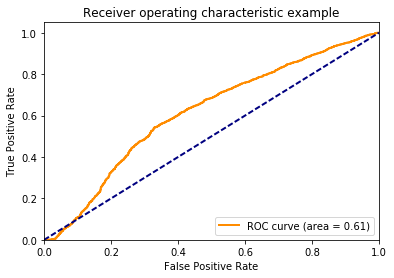

In [65]:
grid = GridSearchCV(LogisticRegression(class_weight='balanced'),param_grid=param_grid,
                    cv=skf.get_n_splits(X_train, y_train))
grid.fit(X_train,y_train)
print('Grid Search using Accuracy as Scoring metric')
print 'Best Parameters: ',grid.best_params_
print('Best cross-validation score: {:.3f}'.format(grid.best_score_))
print('AUC score on test set: {:.3f}'.format(roc_auc_score(y_test,grid.decision_function(X_test))))
print('Test set accuracy:{:.3f}'.format(grid.score(X_test,y_test)))
plot_roc(grid)

Grid Search using Accuracy as Scoring metric
Best Parameters:  {'C': 0.0001}
Best cross-validation score: 0.736
AUC score on test set: 0.608
Test set accuracy:0.739


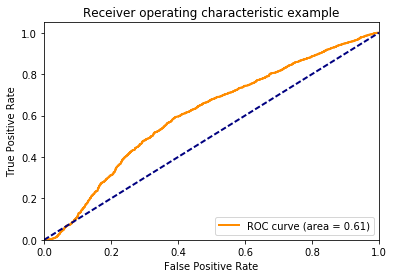

In [66]:
grid = GridSearchCV(LogisticRegression(class_weight='balanced',penalty='l1'),param_grid=param_grid,
                    cv=skf.get_n_splits(X_train, y_train))
grid.fit(X_train,y_train)
print('Grid Search using Accuracy as Scoring metric')
print 'Best Parameters: ',grid.best_params_
print('Best cross-validation score: {:.3f}'.format(grid.best_score_))
print('AUC score on test set: {:.3f}'.format(roc_auc_score(y_test,grid.decision_function(X_test))))
print('Test set accuracy:{:.3f}'.format(grid.score(X_test,y_test)))
plot_roc(grid)

Grid Search using Precision as Scoring metric
Best Parameters:  {'C': 1000}
Best cross-validation score: 0.985
AUC score on test set: 0.615
Test set accuracy:0.985


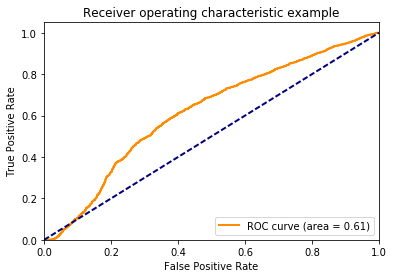

In [67]:
grid = GridSearchCV(LogisticRegression(class_weight='balanced'),param_grid=param_grid,
                    cv=skf.get_n_splits(X_train, y_train), scoring='precision')
grid.fit(X_train,y_train)
print('Grid Search using Precision as Scoring metric')
print 'Best Parameters: ',grid.best_params_
print('Best cross-validation score: {:.3f}'.format(grid.best_score_))
print('AUC score on test set: {:.3f}'.format(roc_auc_score(y_test,grid.decision_function(X_test))))
print('Test set accuracy:{:.3f}'.format(grid.score(X_test,y_test)))
plot_roc(grid)

Grid Search using Recall as Scoring metric
Best Parameters:  {'C': 1e-05}
Best cross-validation score: 0.752
AUC score on test set: 0.613
Test set accuracy:0.751


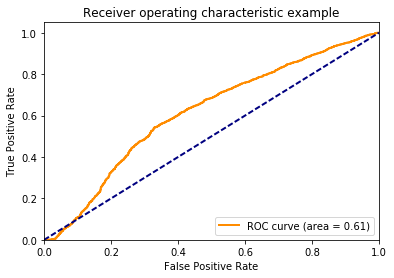

In [68]:
grid = GridSearchCV(LogisticRegression(class_weight='balanced'),param_grid=param_grid,
                    cv=skf.get_n_splits(X_train, y_train), scoring='recall')
grid.fit(X_train,y_train)
print('Grid Search using Recall as Scoring metric')
print 'Best Parameters: ',grid.best_params_
print('Best cross-validation score: {:.3f}'.format(grid.best_score_))
print('AUC score on test set: {:.3f}'.format(roc_auc_score(y_test,grid.decision_function(X_test))))
print('Test set accuracy:{:.3f}'.format(grid.score(X_test,y_test)))
plot_roc(grid)

In [69]:
confusion_matrix(y_test,grid.predict(X_test))

array([[  597,   840],
       [18238, 54870]])

In [70]:
confusion_matrix(y_test,grid.predict(X_test))

array([[  597,   840],
       [18238, 54870]])

In [71]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion matrix, without normalization
[[  597   840]
 [18238 54870]]


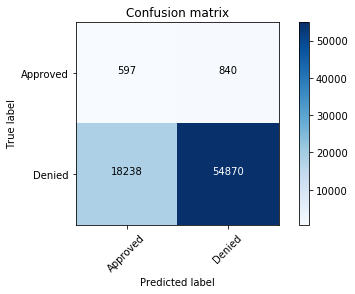

In [72]:
plot_confusion_matrix(confusion_matrix(y_test,grid.predict(X_test)),classes=['Approved','Denied'])

## Section 4: Wrap-Up

In this final section, the results are briefly summarized. In this work, we investigated the H-1B visa data. First, a few questions were answered while exploring the state of the dataset. Throughout the exploration of the data, it became apparent that a lot of the values in various fields were incorrect, requiring a significant amount of cleaning. Some of the issues included missing values, values that didn't make sense for the field (salaries that are unrealistically high), typos in string fields for addresses/states, addresses used for names, etc. Given the limited time constraint, a logistic regression model was built using a small subset of features that could be quickly extracted from the dataset without too much cleaning. This exploration serves mainly as a step-by-step walkthrough of the model buidling process in Python. 

First, the dataset was simplified to visa applications for full-time jobs located in the United State. The entries with missing values or NAICS codes that do not conform to the standard were removed. Five features were engineered from the dataset: sector, subsector, industry, time between (in days), and . The sector, subsector, and industry were extracted from the NAICS code. The time between entries were determined from the corresponding dates in the original dataset.

A large class imbalance was identified. Some of the typical procedures for handling this were discussed. However, a simple correction for class imbalance (adjusting model weights inversely proportional to the class frequencies of the input data) was chosen due to time constraints. It would have been better to include a range of different weight values to include in the GridSearchCV. A typical train-test split of the data was made (ensuring that the ratios of classes is maintained between the test and training sets). A logistic regression model was chosen. The 'C' hyperparameter (inverse of regularization strength) was optimized using a grid search with various scoring methods (accuracy,precision,recall). The type of regularization ('L1','L2') was also varied. ROC curves were plotted. The model hyperparameters for each scoring choice and regularization method were found. 

If I had more time for to investigate this dataset, I would spend significantly more time on the model building portion and try various other models. Additionally, I would do more feature engineering that time didn't permit.